In [51]:
import tensorflow as tf
import tensorflow.python.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Layer
from tensorflow.keras.layers import Input, Dense, Activation, LeakyReLU, Permute, Bidirectional
from tensorflow.keras.layers import Reshape, Lambda, BatchNormalization, LSTM
from tensorflow.python.keras.layers.merge import add, concatenate
# from tensorflow.python.keras.layers.recurrent import LSTM
# from tensorflow.keras.layers import CuDNNLSTM
from primus import CTC_PriMuS
import ctc_utils
import os
import cv2
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [52]:
# !unzip drive/MyDrive/Data/Data.zip

In [53]:
tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

In [54]:
def default_model_params(img_height, vocabulary_size):
    params = dict()
    params['img_height'] = img_height
    params['img_width'] = None
    params['batch_size'] = 16
    params['img_channels'] = 1
    params['conv_blocks'] = 2
    params['conv_filter_n'] = [32, 64]
    params['conv_filter_size'] = [ [3,3], [3,3] ]
    params['conv_pooling_size'] = [ [2,2], [2,2] ]
    params['rnn_units'] = 32
    params['rnn_layers'] = 1
    params['vocabulary_size'] = vocabulary_size
    return params

In [55]:
def CTCLoss(y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64") # 16
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        print("Y_pred shape:  ",y_pred.shape)
        print("Y_true shape:  ",y_true.shape)

        loss = K.ctc_batch_cost(y_true, y_pred, input_length, label_length)
        return loss

In [56]:

def ctc_crnn(params,width_rem = 128):
    input_shape = (params['img_height'],params['img_width'], params['img_channels'])

    inputs = Input(name='image', shape=input_shape, dtype='float32')

    labels = Input(name="label", shape=(None,), dtype="float32")

    width_reduction = 1
    height_reduction = 1

    #conv2d layer
    for i in range(params['conv_blocks']):
            inner = Conv2D(params['conv_filter_n'][i], params['conv_filter_size'][i], padding='same', name='conv'+ str(i+1), kernel_initializer='he_normal')(inputs if i == 0 else inner)
            inner = BatchNormalization()(inner)
            inner = LeakyReLU(0.2)(inner)
            inner = MaxPooling2D(pool_size=params['conv_pooling_size'][i], strides = params['conv_pooling_size'][i], name='max' + str(i+1))(inner)

            width_reduction = width_reduction * params['conv_pooling_size'][i][1]
            height_reduction = height_reduction * params['conv_pooling_size'][i][0]
            print(width_reduction)
    
    print(width_reduction)
    features = K.permute_dimensions(inner, (2,0,3,1))
    feature_dim = params['conv_filter_n'][-1] * (params['img_height'] / height_reduction)
    feature_width = width_rem / width_reduction
    print("Feature width:",feature_width)
    features = tf.reshape(features, tf.stack([tf.cast(feature_width,'int32'), 16, tf.cast(feature_dim,'int32')]))
    
    # RNN block
    lstm_1 = LSTM(params['rnn_units'], return_sequences=True, kernel_initializer='he_normal', name='lstm1')(features)  # (None, 32, 512)
    lstm_1b = LSTM(params['rnn_units'], return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='lstm1_b')(features)
    reversed_lstm_1b = Lambda(lambda inputTensor: K.reverse(inputTensor, axes=1)) (lstm_1b)

    lstm1_merged = add([lstm_1, reversed_lstm_1b])  # (None, 32, 512)
    lstm1_merged = BatchNormalization()(lstm1_merged)
    
    lstm_2 = LSTM(params['rnn_units'], return_sequences=True, kernel_initializer='he_normal', name='lstm2')(lstm1_merged)
    lstm_2b = LSTM(params['rnn_units'], return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='lstm2_b')(lstm1_merged)
    reversed_lstm_2b= Lambda(lambda inputTensor: K.reverse(inputTensor, axes=1)) (lstm_2b)

    lstm2_merged = concatenate([lstm_2, reversed_lstm_2b])  # (None, 32, 1024)
    lstm2_merged = BatchNormalization()(lstm2_merged)

    # transforms RNN output to character activations:
    num_classes = params['vocabulary_size'] + 1
    y_pred = Dense(num_classes, kernel_initializer='he_normal',name='dense2', activation='softmax')(lstm2_merged) #(None, 32, 63)
    # y_pred = Activation('softmax', name='softmax')(inner)

    # output = CTCLayer()(labels, y_pred)


    return Model(inputs=[inputs, labels], outputs=y_pred)

In [57]:
corpus_dirpath = "/content/primusCalvoRizoAppliedSciences2018/"
corpus_filepath = "/content/train.txt"
dictionary_path = "/content/vocabulary_semantic.txt"
primus = CTC_PriMuS(corpus_dirpath,corpus_filepath,dictionary_path, True, val_split = 0.2)

Training with 800 and validating with 200


In [58]:
# Get Data
image_paths = []
image_texts = []

class PriMuS_Data:
    def __init__(self, corpus_dirpath, corpus_filepath, dictionary_path):
        self.corpus_dirpath = corpus_dirpath

        # Corpus
        corpus_file = open(corpus_filepath,'r')
        self.corpus_list = corpus_file.read().splitlines()
        corpus_file.close()

        self.current_idx = 0

        # Dictionary
        self.word2int = {}
        self.int2word = {}
            
        dict_file = open(dictionary_path,'r')
        dict_list = dict_file.read().splitlines()
        for word in dict_list:
            if not word in self.word2int:
                word_idx = len(self.word2int)
                self.word2int[word] = word_idx
                self.int2word[word_idx] = word

        dict_file.close()

        self.vocabulary_size = len(self.word2int)
    
    def get_vocabulary_size(self):
        return self.vocabulary_size
        
    def get_data(self):
        return self.corpus_list

    def encode_seqs(self, seqs):
        encoded = []
        for seq in seqs:
            new_seq=[]
            for sym in seq:
                new_seq.append(self.word2int[sym])
            encoded.append(new_seq)
        return encoded

    def trim_ds(self):
        val_split = 0.9
        folder_path = self.corpus_dirpath
        list_of_files = self.corpus_list #10,000 filenames

        image_paths = [self.corpus_dirpath+f"{x}/{x}.png" for x in self.corpus_list] # list of image paths
        text_paths = [self.corpus_dirpath+f"{x}/{x}.semantic" for x in self.corpus_list]

        image_texts = [] # list of strings

        for path in text_paths:
            with open(path, "r") as file:
                image_texts.append(file.readline().split())

        image_texts = self.encode_seqs(image_texts)

        max_label_len = max([len(seq) for seq in image_texts])
        padded_image_texts = pad_sequences(image_texts, maxlen=max_label_len, padding='post', value= self.vocabulary_size + 1)

        # TODO: do line 17 from the link : https://github.com/rajesh-bhat/spark-ai-summit-2020-text-extraction/blob/master/CRNN_CTC_wandb.ipynb

        # TODO: Use self.word2int to encode each element of the lists in image_texts
        # Input image_texts = [  ['clef','C-note'] , [.......], ....]
        # Final image_texts = [  [5,3] , [.......], ....]
        # if 'clef' == 5, 'C-note' == 3 in word2int dictionary
        # Also add padding using the function below so length of each element is consistent

        # from tensorflow.keras.preprocessing.sequence import pad_sequences
        # padded_image_texts = list(map(encode_to_labels, image_texts))
        # padded_image_texts[0]


        train_image_paths = image_paths[ : int(len(image_paths) * val_split)]
        train_image_texts = padded_image_texts[ : int(len(padded_image_texts) * val_split)]

        val_image_paths = image_paths[int(len(image_paths) * val_split) : ]
        val_image_texts = padded_image_texts[int(len(padded_image_texts) * val_split) : ]

        return {"train":{"images":train_image_paths, "text": train_image_texts}, "val":{"images":val_image_paths, "text": val_image_texts}}



In [59]:
data_obj = PriMuS_Data(corpus_dirpath, corpus_filepath, dictionary_path)
lst = data_obj.trim_ds()

In [60]:
# TODO: do line 17 from the link : https://github.com/rajesh-bhat/spark-ai-summit-2020-text-extraction/blob/master/CRNN_CTC_wandb.ipynb

In [61]:
lst["train"]["text"][0]

array([   1,  229, 1757,  236,    0,  687, 1280, 1303, 1303,  823,    0,
        490,  490, 1727, 1727,    0, 1470, 1304,  853,  679,  501,    0,
        490, 1599, 1727, 1782, 1782, 1782, 1782, 1782, 1782, 1782, 1782,
       1782, 1782, 1782, 1782, 1782, 1782, 1782, 1782, 1782, 1782, 1782,
       1782, 1782, 1782, 1782, 1782, 1782, 1782, 1782, 1782, 1782, 1782,
       1782], dtype=int32)

In [62]:
# Resize images to desired dimensions with unknown width
def resize_no_width(image, height):
    width = int(float(height * image.shape[1]) / image.shape[0])
    sample_img = cv2.resize(image, (width, height))
    return sample_img


# Pre-process a single image sample(resize/normalize/max_width resize)
def process_single_sample(img_path, label,max_width = 30):
    params = default_model_params(img_height,primus.vocabulary_size)
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img,[params['img_height'], max_width])
    # TODO: Get height from params, calculate width from max of all images
    return {"image": img, "label": label}


In [63]:
# !unzip drive/MyDrive/Data/Data.zip

In [64]:
batch_size = 16


image_widths = [cv2.imread(img).shape[1] for img in lst["train"]["images"]]
max_image_width = max(image_widths)
print(max_image_width)
# Parameterization
img_height = 64
params = default_model_params(img_height,primus.vocabulary_size)
max_epochs = 100
dropout = 0.5
# Model
model = ctc_crnn(params, width_rem= max_image_width)
model.summary()

# Pre-process a single image sample(resize/normalize/max_width resize)
def process_single_sample(img_path, label):
    params = default_model_params(img_height,primus.vocabulary_size)
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img,[params['img_height'], max_image_width])
    # TODO: Get height from params, calculate width from max of all images
    return {"image": img, "label": label}
# train_dataset = train_dataset.map(process_single_sample(max_width = max_image_width))

# processed_images = [process_single_sample(img,label,max_image_width) for img,label in zip(lst["train"]["images"], lst["train"]["text"])]

train_dataset = tf.data.Dataset.from_tensor_slices((lst['train']['images'], lst['train']['text']))

train_dataset = (
    train_dataset.map(
        process_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((lst['train']['images'], lst['train']['text']))
validation_dataset = (
    validation_dataset.map(
        process_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

2003
2
4
4
Feature width: 500.75
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 64, None, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 64, None, 32  320         ['image[0][0]']                  
                                )                                                                 
                                                                                                  
 batch_normalization_16 (BatchN  (None, 64, None, 32  128        ['conv1[0][0]']                  
 ormalization)                  )                          

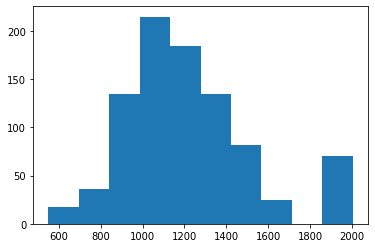

In [65]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.Series(image_widths)
plt.hist(df)
plt.show()

https://github.com/rajesh-bhat/spark-ai-summit-2020-text-extraction/blob/master/CRNN_CTC_wandb.ipynb

In [66]:
# Compile

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
model.compile(optimizer= optimizer, loss = CTCLoss)

# checkpoint = ModelCheckpoint(filepath=file_path, 
#                                 monitor='val_loss', 
#                                 verbose=1, 
#                                 save_best_only=True, 
#                                 mode='min')

#     callbacks_list = [checkpoint, 
#                       WandbCallback(monitor="val_loss", 
#                                     mode="min", 
#                                     log_weights=True),
#                       PlotPredictions(frequency=1),
#                       EarlyStopping(patience=3, verbose=1)]

history = model.fit(train_dataset, 
                    epochs = max_epochs,
                    validation_data=validation_dataset,
                    verbose = 1,
                    # callbacks = callbacks_list,
                    shuffle=True)

Epoch 1/100


ValueError: ignored